## Softmax Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pca import PCA
import argparse
import network
import os, random, sys
from data import traffic_sign, generate_k_fold_set, onehot_encode, onehot_decode, z_score_normalize, append_bias
from model.softmax import SoftmaxRegression

In [2]:
### Q6(a) - Evaluate Network on all 43 traffic signs (aligned dataset)

# Load aligned data
X, y = traffic_sign(True)
X = X.astype(np.float32) # cast to float32 as float64 running out of memory
X = z_score_normalize(X) 

print(X.shape)
print(y.shape)
print(X.dtype)
print(y.dtype)

(34799, 1024)
(34799,)
float32
uint8


Current Fold: 0


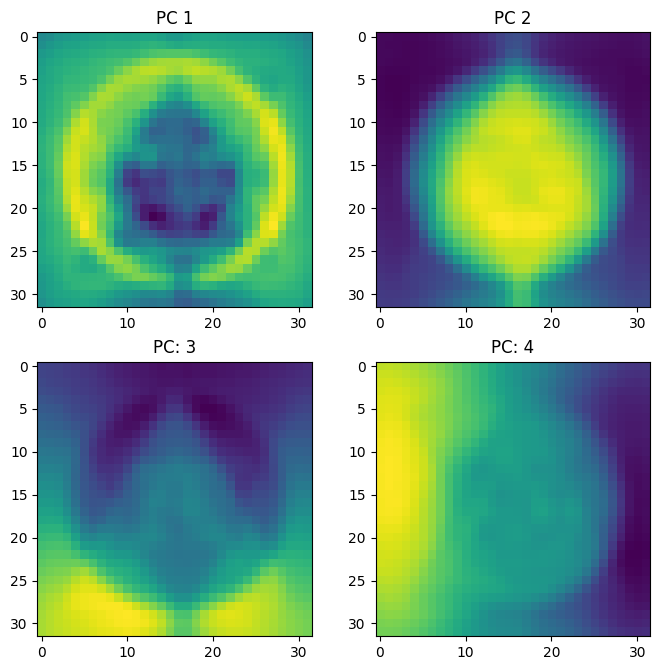

(27841, 300)
(3479, 300)
(3479, 300)
 epoch: 50, train accuracy: 0.8385, train_loss_norm:0.0298, valid_acc: 0.8341, valid_loss_norm: 0.0444
MODEL_W: Test accuracy: 0.8183 Test loss norm: 0.0486
MODEL: Test accuracy: 0.8183
 epoch: 100, train accuracy: 0.8599, train_loss_norm:0.0219, valid_acc: 0.8511, valid_loss_norm: 0.0399
MODEL_W: Test accuracy: 0.8382 Test loss norm: 0.0433
MODEL: Test accuracy: 0.8382
 epoch: 150, train accuracy: 0.8726, train_loss_norm:0.0184, valid_acc: 0.8603, valid_loss_norm: 0.0374
MODEL_W: Test accuracy: 0.8471 Test loss norm: 0.0409
MODEL: Test accuracy: 0.8471
 epoch: 200, train accuracy: 0.8830, train_loss_norm:0.0164, valid_acc: 0.8655, valid_loss_norm: 0.0360
MODEL_W: Test accuracy: 0.8543 Test loss norm: 0.0390
MODEL: Test accuracy: 0.8543
 epoch: 250, train accuracy: 0.8909, train_loss_norm:0.0149, valid_acc: 0.8707, valid_loss_norm: 0.0346
MODEL_W: Test accuracy: 0.8580 Test loss norm: 0.0380
MODEL: Test accuracy: 0.8580
 epoch: 300, train accuracy: 

In [3]:
## (i) With PCA on aligned

DEBUG = False

# Softmax Regression Parameters
lr = 0.5
num_features = X.shape[1]
num_classes = y.max() + 1

train_loss_record = []

train_accuracy_record = []

holdout_loss_record = []

holdout_accuracy_record = []

test_accuracy_record = []

# PCA number of principal components
n_components = 300

first_plot = True

num_epochs = 300
epochs_print = [50, 100, 150, 200, 250, 300]

k = 10

total_test_accuracy = 0.0
total_test_loss = 0.0

cur_fold = 0
for train, valid, test in generate_k_fold_set((X, y), k):
    print(f"Current Fold: {cur_fold}")
    train_data, train_label = train
    valid_data, valid_label = valid
    test_data, test_label = test
    
    # Project data onto principal components
    pca = PCA(n_components)
    projected = pca.fit_transform(train_data) # len(train_data) x n_components
    
    # Plot principal components
    if first_plot == True : 
        pca.plot_PC()
        first_plot = False
    train_d = append_bias(projected)     
    valid_d = append_bias(pca.PCA_generate(valid_data))
    test_d = append_bias(pca.PCA_generate(test_data))

    softmax_model = SoftmaxRegression(lr, n_components, num_classes)
    best_w = softmax_model.W

    # Onehot encode labels
    y_true = onehot_encode(train_label)
    valid_label_onehot = onehot_encode(valid_label)
    test_label_onehot = onehot_encode(test_label)
    
    for epoch in range(num_epochs):
        y_hat = softmax_model.model(train_d)
        
        raw_train_loss = softmax_model.cross_entropy(y_true, y_hat)
        train_loss_norm = raw_train_loss / len(train_d) / num_classes # train loss normalized by # examples and classes
        
        train_loss_record.append(train_loss_norm)
        
        train_accuracy = softmax_model.accuracy(y_true, y_hat)
        train_accuracy_record.append(train_accuracy)
        
        holdout_y = softmax_model.model(valid_d)

        holdout_loss = softmax_model.cross_entropy(holdout_y, valid_label_onehot)
        holdout_loss_norm = holdout_loss / len(valid_d) / num_classes # holdout loss normalized by # examples and classes
        holdout_loss_record.append(holdout_loss_norm)

        holdout_accuracy = softmax_model.accuracy(holdout_y, valid_label_onehot)
        holdout_accuracy_record.append(holdout_accuracy)

        if holdout_accuracy >= max(holdout_accuracy_record[cur_fold * num_epochs:]):
            best_w = softmax_model.W

        # Update Weights
        softmax_model.update_weights(train_d, y_true, y_hat)

        if (epoch + 1) in epochs_print:
            print(f' epoch: {epoch + 1}, train accuracy: {train_accuracy:.4f}, train_loss_norm:{train_loss_norm:.4f}, '\
                f'valid_acc: {holdout_accuracy:.4f}, valid_loss_norm: {holdout_loss_norm:.4f}')
            if DEBUG:
                test_y = softmax_model.model_w(test_d, best_w)
                test_y_1 = softmax_model.model(test_d)

                test_accuracy = softmax_model.accuracy(test_y, test_label_onehot)
                test_accuracy_1 = softmax_model.accuracy(test_y_1, test_label_onehot)

                raw_test_loss = softmax_model.cross_entropy(test_y, test_label_onehot)
                test_loss_norm = raw_test_loss / len(test_d) / num_classes

                print(f'MODEL_W: Test accuracy: {test_accuracy:.4f}', f'Test loss norm: {test_loss_norm:.4f}')
                print(f'MODEL: Test accuracy: {test_accuracy_1:.4f}')

    # Run on Test Dataset
    test_y = softmax_model.model_w(test_d, best_w)

    test_accuracy = softmax_model.accuracy(test_y, test_label_onehot)

    print(f'Test accuracy: {test_accuracy:.4f}')

    total_test_accuracy += test_accuracy

    raw_test_loss = softmax_model.cross_entropy(test_y, test_label_onehot)
    test_loss_norm = raw_test_loss / len(test_d) / num_classes
    total_test_loss += test_loss_norm
    print(f"Test loss norm: {test_loss_norm:.4f}")

    cur_fold += 1

print(f'Average test accuracy over {k} folds: {total_test_accuracy / k}')
print(f'Average test loss per example and class over {k} folds: {total_test_loss / k}')


In [4]:
def average_out_data_k(data, k=10):
    total_count = len(data)
    count_per_fold = total_count // k # Assumes cleanly divisble number
    new_data = [0.0 for i in range(count_per_fold)]
    for i in range(k):
        for j in range(count_per_fold):
            new_data[j] += data[i * count_per_fold + j]
    new_data = [d / k for d in new_data]
    return new_data

def get_data_at_epoch_fold(data, epoch, total_num_folds=10):
    # Returns a new list of data points at a specified epoch from all folds
    # data = [fold1....fold10]
    # epoch is 0-indexed
    epoch_per_fold = len(data) // total_num_folds
    new_data = [data[f * (epoch_per_fold) + epoch] for f in range(total_num_folds)]
    return new_data # [epoch n from fold1, epoch n from fold2, ..., epoch n from fold10]



In [5]:
fig, axs = plt.subplots(2, 1, constrained_layout=True)

epochs_error_bar = [50, 100, 150, 200, 250, 300] # 1-indexed
epochs_error_bar_0 = [epoch - 1 for epoch in epochs_error_bar] # 0-indexed

# Plot Loss
average_train_loss = average_out_data_k(train_loss_record)
train_loss_error_bar_y = [average_train_loss[epoch] for epoch in epochs_error_bar_0]
train_loss_error_bar_yerr = [np.std(get_data_at_epoch_fold(train_loss_record, epoch)) for epoch in epochs_error_bar_0]

average_valid_loss = average_out_data_k(holdout_loss_record)
valid_loss_error_bar_y = [average_valid_loss[epoch] for epoch in epochs_error_bar_0]
valid_loss_error_bar_yerr = [np.std(get_data_at_epoch_fold(holdout_loss_record, epoch)) for epoch in epochs_error_bar_0]

axs[0].plot(average_train_loss, '-b', label='Training loss')
axs[0].errorbar(x=epochs_error_bar_0, y=train_loss_error_bar_y, yerr=train_loss_error_bar_yerr, label='Training loss error', fmt='-b')

axs[0].plot(average_valid_loss, '--r', label='Validation loss')
axs[0].errorbar(x=epochs_error_bar_0, y=valid_loss_error_bar_y, yerr=valid_loss_error_bar_yerr, label='Validation loss error', fmt='--r')

axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Normalized Loss')
axs[0].set_title('Loss normalized per example and class vs. Epochs')

# Plot Accuracy
average_train_acc = average_out_data_k(train_accuracy_record)
train_acc_error_bar_y = [average_train_acc[epoch] for epoch in epochs_error_bar_0]
train_acc_error_bar_yerr = [np.std(get_data_at_epoch_fold(train_accuracy_record, epoch)) for epoch in epochs_error_bar_0]

average_valid_acc = average_out_data_k(holdout_accuracy_record)
valid_acc_error_bar_y = [average_valid_acc[epoch] for epoch in epochs_error_bar_0]
valid_acc_error_bar_yerr = [np.std(get_data_at_epoch_fold(holdout_accuracy_record, epoch)) for epoch in epochs_error_bar_0]

axs[1].plot(average_train_acc, '-b', label='Training accuracy')
axs[1].errorbar(x=epochs_error_bar_0, y=train_acc_error_bar_y, yerr=train_acc_error_bar_yerr, label='Training accuracy error', fmt='-b')

axs[1].plot(average_valid_acc, '--r', label='Validation accuracy')
axs[1].errorbar(x=epochs_error_bar_0, y=valid_acc_error_bar_y, yerr=valid_acc_error_bar_yerr, label='Validation accuracy error', fmt='--r')

axs[1].legend()
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy vs. Epochs')

plt.savefig("plots/Q6a_i.png")
plt.close(fig)


In [6]:
## (ii) Without PCA on aligned and with PCA on unaligned
## 1. Without PCA on aligned

print("(ii)")
print("Without PCA on aligned")

# Softmax Regression Parameters
lr = 0.5
num_features = X.shape[1]
num_classes = y.max() + 1

train_loss_record = []

train_accuracy_record = []

holdout_loss_record = []

holdout_accuracy_record = []

test_accuracy_record = []

num_epochs = 300
epochs_print = [50, 100, 150, 200, 250, 300]

k = 10

total_test_accuracy = 0.0
total_test_loss = 0.0

cur_fold = 0
for train, valid, test in generate_k_fold_set((X, y), k):
    print(f"Current Fold: {cur_fold}")
    train_data, train_label = train
    valid_data, valid_label = valid
    test_data, test_label = test
    
    train_d = append_bias(train_data)     
    valid_d = append_bias(valid_data)
    test_d = append_bias(test_data)

    softmax_model = SoftmaxRegression(lr, num_features, num_classes)
    best_w = softmax_model.W

    # Onehot encode labels
    y_true = onehot_encode(train_label)
    valid_label_onehot = onehot_encode(valid_label)
    test_label_onehot = onehot_encode(test_label)
    
    for epoch in range(num_epochs):
        y_hat = softmax_model.model(train_d)
        
        raw_train_loss = softmax_model.cross_entropy(y_true, y_hat)
        train_loss_norm = raw_train_loss / len(train_d) / num_classes # train loss normalized by # examples and classes
        
        train_loss_record.append(train_loss_norm)
        
        train_accuracy = softmax_model.accuracy(y_true, y_hat)
        train_accuracy_record.append(train_accuracy)
        
        # TODO: early stopping, plotting std.dev., etc.
        holdout_y = softmax_model.model(valid_d)


        holdout_loss = softmax_model.cross_entropy(holdout_y, valid_label_onehot)
        holdout_loss_norm = holdout_loss / len(valid_d) / num_classes # holdout loss normalized by # examples and classes
        holdout_loss_record.append(holdout_loss_norm)

        holdout_accuracy = softmax_model.accuracy(holdout_y, valid_label_onehot)
        holdout_accuracy_record.append(holdout_accuracy)

        # if holdout_accuracy >= max(holdout_accuracy_record):
        if holdout_accuracy >= max(holdout_accuracy_record[cur_fold * num_epochs:]):
            best_w = softmax_model.W

        # Update Weights
        softmax_model.update_weights(train_d, y_true, y_hat)

        if (epoch + 1) in epochs_print:
            print(f' epoch: {epoch + 1}, train accuracy: {train_accuracy:.4f}, train_loss_norm:{train_loss_norm:.4f}, '\
                f'valid_acc: {holdout_accuracy:.4f}, valid_loss_norm: {holdout_loss_norm:.4f}')

    # Run on Test Dataset
    test_y = softmax_model.model_w(test_d, best_w)

    test_accuracy = softmax_model.accuracy(test_y, test_label_onehot)

    print(f'Test accuracy: {test_accuracy:.4f}')

    total_test_accuracy += test_accuracy

    raw_test_loss = softmax_model.cross_entropy(test_y, test_label_onehot)
    test_loss_norm = raw_test_loss / len(test_d) / num_classes
    total_test_loss += test_loss_norm
    print(f"Test loss norm: {test_loss_norm:.4f}")

    cur_fold += 1

print(f'Average test accuracy over {k} folds: {total_test_accuracy / k}')
print(f'Average test loss per example and class over {k} folds: {total_test_loss / k}')


In [ ]:
fig, axs = plt.subplots(2, 1, constrained_layout=True)

epochs_error_bar = [50, 100, 150, 200, 250, 300] # 1-indexed
epochs_error_bar_0 = [epoch - 1 for epoch in epochs_error_bar] # 0-indexed

# Plot Loss
average_train_loss = average_out_data_k(train_loss_record)
train_loss_error_bar_y = [average_train_loss[epoch] for epoch in epochs_error_bar_0]
train_loss_error_bar_yerr = [np.std(get_data_at_epoch_fold(train_loss_record, epoch)) for epoch in epochs_error_bar_0]

average_valid_loss = average_out_data_k(holdout_loss_record)
valid_loss_error_bar_y = [average_valid_loss[epoch] for epoch in epochs_error_bar_0]
valid_loss_error_bar_yerr = [np.std(get_data_at_epoch_fold(holdout_loss_record, epoch)) for epoch in epochs_error_bar_0]

axs[0].plot(average_train_loss, '-b', label='Training loss')
axs[0].errorbar(x=epochs_error_bar_0, y=train_loss_error_bar_y, yerr=train_loss_error_bar_yerr, label='Training loss error', fmt='-b')

axs[0].plot(average_valid_loss, '--r', label='Validation loss')
axs[0].errorbar(x=epochs_error_bar_0, y=valid_loss_error_bar_y, yerr=valid_loss_error_bar_yerr, label='Validation loss error', fmt='--r')

axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Normalized Loss')
axs[0].set_title('Loss normalized per example and class vs. Epochs')

# Plot Accuracy
average_train_acc = average_out_data_k(train_accuracy_record)
train_acc_error_bar_y = [average_train_acc[epoch] for epoch in epochs_error_bar_0]
train_acc_error_bar_yerr = [np.std(get_data_at_epoch_fold(train_accuracy_record, epoch)) for epoch in epochs_error_bar_0]

average_valid_acc = average_out_data_k(holdout_accuracy_record)
valid_acc_error_bar_y = [average_valid_acc[epoch] for epoch in epochs_error_bar_0]
valid_acc_error_bar_yerr = [np.std(get_data_at_epoch_fold(holdout_accuracy_record, epoch)) for epoch in epochs_error_bar_0]

axs[1].plot(average_train_acc, '-b', label='Training accuracy')
axs[1].errorbar(x=epochs_error_bar_0, y=train_acc_error_bar_y, yerr=train_acc_error_bar_yerr, label='Training accuracy error', fmt='-b')

axs[1].plot(average_valid_acc, '--r', label='Validation accuracy')
axs[1].errorbar(x=epochs_error_bar_0, y=valid_acc_error_bar_y, yerr=valid_acc_error_bar_yerr, label='Validation accuracy error', fmt='--r')

axs[1].legend()
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy vs. Epochs')

plt.savefig("plots/Q6a_ii_1.png")
plt.close(fig)


In [ ]:
## With PCA on unaligned

In [7]:
## (iii) Confusion Matrix on Test Set results
# TODO

Q6(b) - Stochastic Gradient Descent
Cur fold: 0


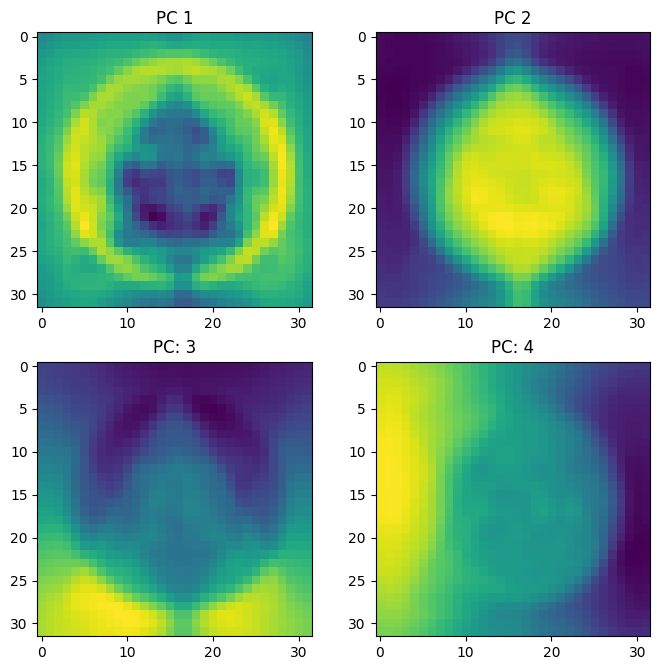

(27841, 300)
(3479, 300)
(3479, 300)
0
 epoch: 1, train accuracy: 0.7892, train_loss_norm:0.0837, valid_acc: 0.8661, valid_loss_norm: 0.0359
1
 epoch: 2, train accuracy: 0.7893, train_loss_norm:0.0800, valid_acc: 0.8661, valid_loss_norm: 0.0359
2
 epoch: 3, train accuracy: 0.7895, train_loss_norm:0.0764, valid_acc: 0.8661, valid_loss_norm: 0.0359
3
 epoch: 4, train accuracy: 0.7903, train_loss_norm:0.0730, valid_acc: 0.8661, valid_loss_norm: 0.0359
4
 epoch: 5, train accuracy: 0.7913, train_loss_norm:0.0698, valid_acc: 0.8661, valid_loss_norm: 0.0359
5
 epoch: 6, train accuracy: 0.7921, train_loss_norm:0.0668, valid_acc: 0.8661, valid_loss_norm: 0.0359
6
 epoch: 7, train accuracy: 0.7932, train_loss_norm:0.0641, valid_acc: 0.8661, valid_loss_norm: 0.0359
7
 epoch: 8, train accuracy: 0.7943, train_loss_norm:0.0616, valid_acc: 0.8661, valid_loss_norm: 0.0359
8
 epoch: 9, train accuracy: 0.7958, train_loss_norm:0.0593, valid_acc: 0.8661, valid_loss_norm: 0.0359
9
 epoch: 10, train accurac

KeyboardInterrupt: 

In [8]:
### Q6(b) - Stochastic Gradient Descent

print("Q6(b) - Stochastic Gradient Descent")

# Softmax Regression Parameters
lr = 0.5
num_features = X.shape[1]
num_classes = y.max() + 1

train_loss_record = []
train_accuracy_record = []
holdout_loss_record = []
holdout_accuracy_record = []
test_accuracy_record = []


# PCA number of principal components
n_components = 300

first_plot = True

num_epochs = 300
epochs_print = [50, 100, 150, 200, 250, 300]

cur_fold = 0

for train, valid, test in generate_k_fold_set((X, y), k = 10):
    print("Cur fold:", cur_fold)
    train_data, train_label = train
    valid_data, valid_label = valid
    test_data, test_label = test
    
    # Project data onto principal components
    pca = PCA(n_components)
    projected = pca.fit_transform(train_data)
    
    # Plot principal components
    if first_plot == True : 
        pca.plot_PC()
        first_plot = False
    train_d = append_bias(projected)     
    valid_d = append_bias(pca.PCA_generate(valid_data))
    test_d = append_bias(pca.PCA_generate(test_data))

    softmax_model = SoftmaxRegression(lr, n_components, num_classes)

    valid_label_onehot = onehot_encode(valid_label)

    # SGD
    for epoch in range(num_epochs):
        print(epoch)
        # Shuffle indices
        indices = np.arange(len(train_d))
        indices = np.random.shuffle(indices)

        train_d = train_d[indices].squeeze(0)
        train_label = train_label[indices].squeeze(0)
        
        # Onehot encode labels
        y_true = onehot_encode(train_label)
            
        # Iterate over each example
        for i in range(len(train_d)):
            cur_ex = train_d[i][np.newaxis, :]
            cur_label = y_true[i][np.newaxis, :]
            y_hat = softmax_model.model(cur_ex)

            # Update Weights
            softmax_model.update_weights(cur_ex, cur_label, y_hat)

        # Training Loss
        y_hat = softmax_model.model(train_d)

        raw_train_loss = softmax_model.cross_entropy(y_true, y_hat)
        train_loss_norm = raw_train_loss / len(train_d) / num_classes

        train_loss_record.append(raw_train_loss)

        train_accuracy = softmax_model.accuracy(y_true, y_hat)
        train_accuracy_record.append(train_accuracy)

        # # Validation Loss
        # holdout_y = softmax_model.model(valid_d)

        # holdout_loss = softmax_model.cross_entropy(holdout_y, valid_label_onehot)
        # holdout_loss_norm = holdout_loss / len(valid_d) / num_classes # holdout loss normalized by # examples and classes
        # holdout_loss_record.append(holdout_loss_norm)

        # holdout_accuracy = softmax_model.accuracy(holdout_y, valid_label_onehot)
        # holdout_accuracy_record.append(holdout_accuracy)

        # if holdout_accuracy >= max(holdout_accuracy_record):
        #     best_w = softmax_model.W

        
        # if (epoch + 1) in epochs_print:
        print(f' epoch: {epoch + 1}, train accuracy: {train_accuracy:.4f}, train_loss_norm:{train_loss_norm:.4f}, '\
            f'valid_acc: {holdout_accuracy:.4f}, valid_loss_norm: {holdout_loss_norm:.4f}')

    # Run on Test Dataset
    test_y = softmax_model.model_w(test_d, best_w)

    test_label_onehot = onehot_encode(test_label)
    test_accuracy = softmax_model.accuracy(test_y, test_label_onehot)

    print(f'Test accuracy: {test_accuracy:.4f}')

    total_test_accuracy += test_accuracy

    raw_test_loss = softmax_model.cross_entropy(test_y, test_label_onehot)
    total_test_loss += raw_test_loss / len(test_d) / num_classes

    cur_fold += 1

In [ ]:
### (c) Visualize the weights

def weights2range(w, min=0, max=256):
    # Scales weights to be between min and max
    w /= np.max(w)
    w *= (max)
    w += min
    return w

# Plot image